# 07.02 - Modeling - Baseline Model

## Imports & setup

In [1]:
import pathlib
import warnings
from datetime import datetime
import sys
import pickle
import joblib
import gc

import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


# Imports
sys.path.append("..")
from src.utils.utils import (AnnualTimeSeriesSplit,
                             RollingAnnualTimeSeriesSplit,
                             bound_precision,
                             save_run_results,
                             run_cross_val,
                             run_data_split_cross_val)
from src.features.features import CyclicalToCycle
from src.models.models import SetTempAsPower
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot)
#b # Packages
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm


# Display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
figsize=(15,7)
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

## Load Daily Data & Inspect

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
df_cut = df.loc['1994': '2008'].copy(deep=True)
y = df_cut.pop('daily_peak')
X = df_cut
X.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0


In [4]:
y.tail()

2008-09-29    18338.0
2008-09-30    17977.0
2008-10-01    18168.0
2008-10-02    18256.0
2008-10-03    17495.0
Name: daily_peak, dtype: float64

## Apply Cyclical Processing to Temporal Features and Scale Features

In [5]:
n_splits=10
baseline_model = SetTempAsPower()
ratscv = RollingAnnualTimeSeriesSplit(n_splits=n_splits, goback_years=5)

robust_scaler_cols = ['hmdxx_min', 'hmdxx_max', 'hmdxx_median-1', 'temp_min', 'temp_max',
                      'dew_point_temp_max', 'visibility_mean']
steps = [('cyclical0', CyclicalToCycle('hmdxx_max_hour', 24)),
         ('cyclical1', CyclicalToCycle('sun_rise', 24)),
         ('cyclical2', CyclicalToCycle('sun_set', 24)),
         ('cyclical3', CyclicalToCycle('day_of_week', 5)),
         ('cyclical4', CyclicalToCycle('week_of_year', 20)),
         ('robust_scaler', SelectiveRobustScaler(cols=robust_scaler_cols, trans_col_name=robust_scaler_cols)),
         ('baseline', baseline_model)]
pipeline = Pipeline(steps)
d = run_cross_val(X, y, ratscv, pipeline, scoring=['mae', 'bound_precision'])
print(d)
print('Train')
print(np.mean(d['train']['mae']))
print(np.mean(d['train']['bound_precision']))
print('Test')
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound_precision']))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
{'train': {'mae': [1371.246820175438, 1785.5496470099658, 1780.0570655397391, 2060.52602124183, 1963.1688657407392, 1778.7267701525027, 1538.3176823843426, 1656.7882119304534, 2189.313719135805, 2241.1901929012342], 'bound_precision': [0.0, 0.4, 0.6, 0.6, 0.4, 0.4, 0.6, 0.0, 0.4, 0.4]}, 'test': {'mae': [785.34100877193, 841.4966431339972, 971.010972716489, 1120.4177559912857, 1576.4178240740723, 1447.3944376361626, 1137.3077179715308, 1502.9609937050343, 2523.4353780864226, 2433.3100308641974], 'bound_precision': [0.6, 0.8, 0.6, 0.4, 0.6, 0.6, 0.2, 0.8, 0.6, 0.8]}}
Train
1836.4884996212052
0.38
Test
1433.909276295112
0.5999999999999999


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


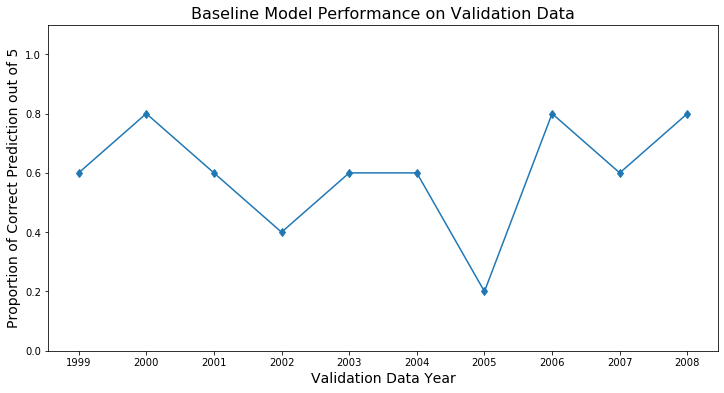

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
x = [str(y) for y in range(1999,2009,1)]
ax.plot(x, d['test']['bound_precision'], marker='d')
ax.set_ylim(0, 1.1, 1)
ax.set_title('Baseline Model Performance on Validation Data', fontsize=16)
ax.set_xlabel('Validation Data Year', fontsize=14)
ax.set_ylabel('Proportion of Correct Prediction out of 5', fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'baseline-model-validation-performance.PNG',
            bbox_inches='tight')
plt.show()

In [7]:
pred_vals = baseline_model.get_pred_values()
pred_vals.loc['2008' , 'y'] = y.loc['2008'].values
pred_vals['resid'] = pred_vals['y'].subtract(pred_vals['yhat'])
pred_vals

,y,yhat,yhat_lower,yhat_upper,is_forecast,resid
2003-05-20,18599.0,19880.870370,NaN,NaN,0,-1281.870370
2003-05-21,17622.0,19707.111111,NaN,NaN,0,-2085.111111
2003-05-22,17662.0,19568.103704,NaN,NaN,0,-1906.103704
2003-05-23,17713.0,20019.877778,NaN,NaN,0,-2306.877778
2003-05-26,17990.0,20506.403704,NaN,NaN,0,-2516.403704
...,...,...,...,...,...,...
2008-09-29,18338.0,19324.840741,NaN,NaN,1,-986.840741
2008-09-30,17977.0,20575.907407,NaN,NaN,1,-2598.907407
2008-10-01,18168.0,19081.577778,NaN,NaN,1,-913.577778
2008-10-02,18256.0,18734.059259,NaN,NaN,1,-478.059259


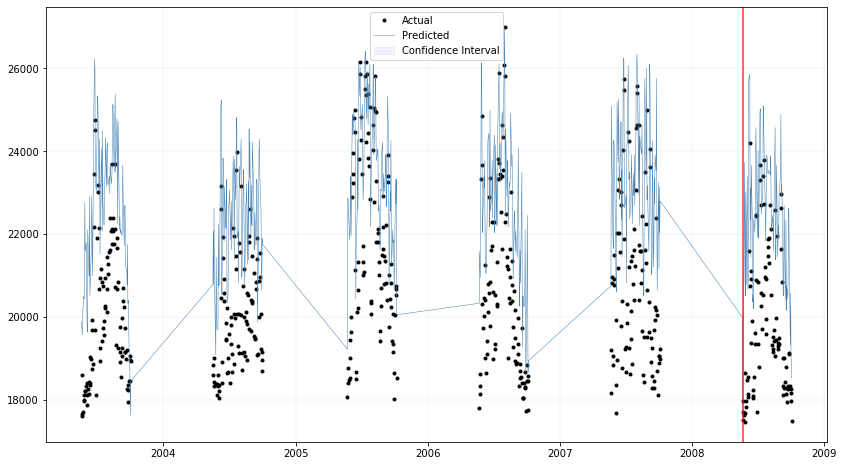

In [8]:
fig, ax = plot_prediction(pred_vals, goback_years=10)
plt.show();

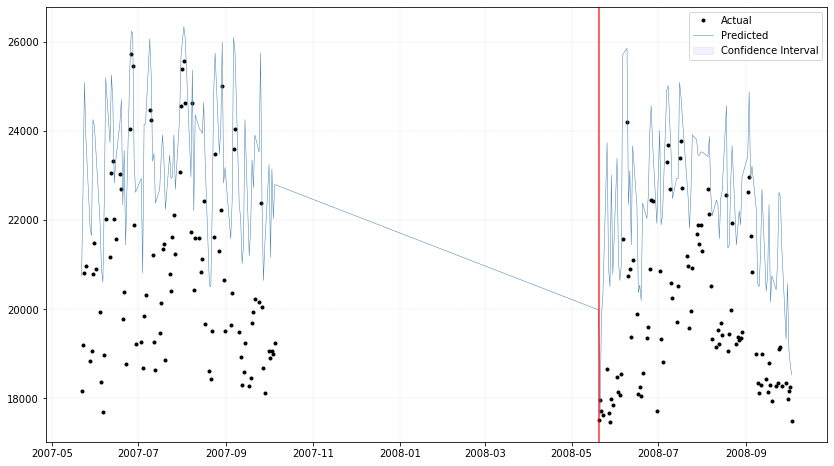

In [9]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
plt.show();

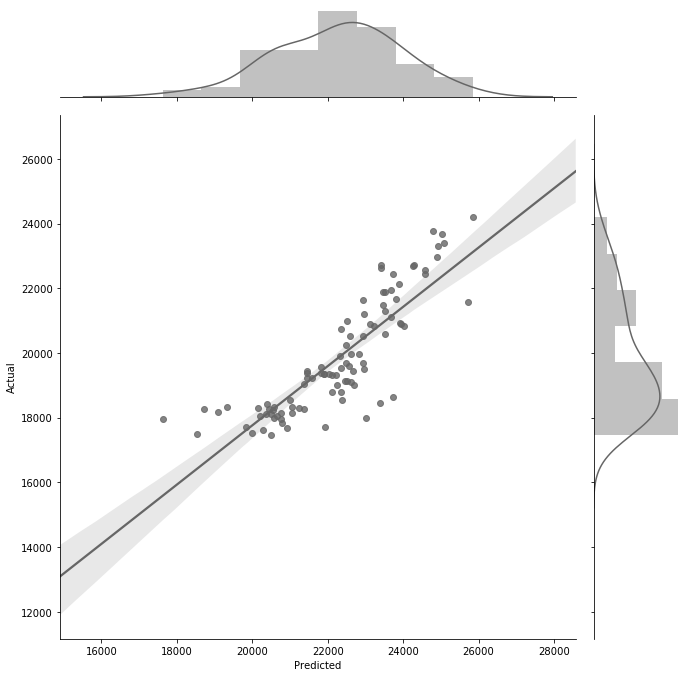

In [10]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.show();

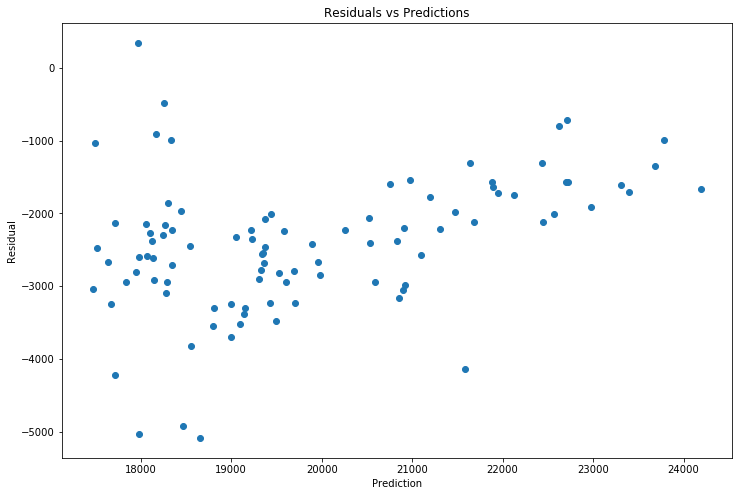

In [11]:
fig, ax = resids_vs_preds_plot(pred_vals)
plt.show()

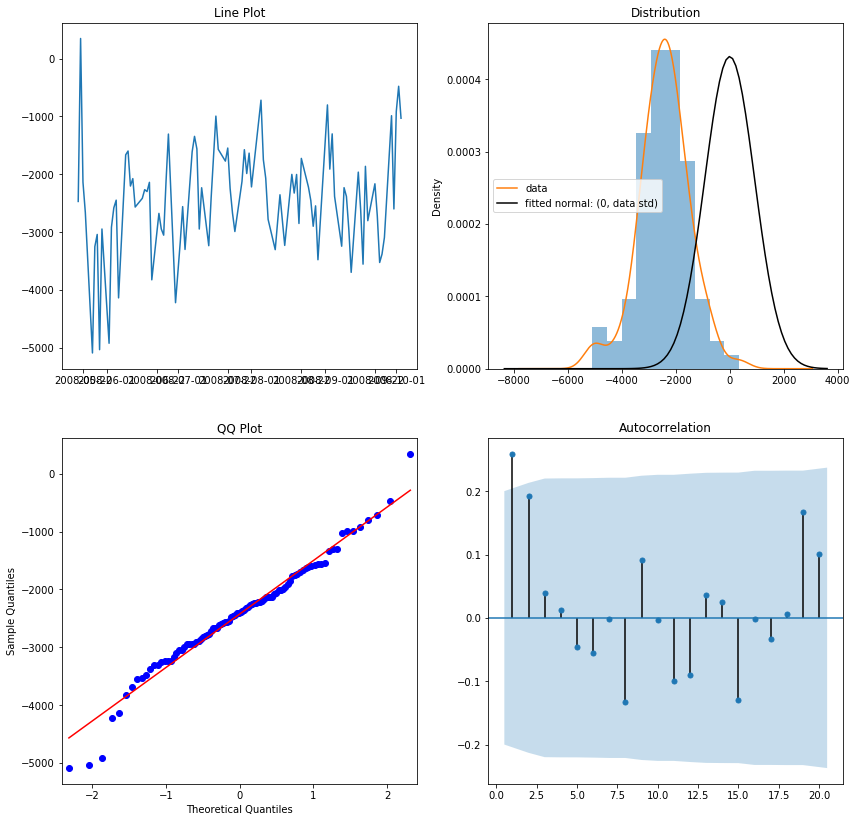

In [12]:
fig, ax = residual_plots(pred_vals)
plt.show()

In [13]:
print_residual_stats(pred_vals)

LJung Box Corr p value:		0.17877
Jarque Bera Normal p value:	0.06545


#### Comment on Residuals

The residuals are a bit meaningless here because the model is not using any loss function to minimize the error

In [14]:
df = save_run_results(X, n_splits, 'Baseline', d, RESULTS_PATH)
df

Baseline                
              mae bound_precision
1999   785.341009             0.6
2000   841.496643             0.8
2001   971.010973             0.6
2002  1120.417756             0.4
2003  1576.417824             0.6
2004  1447.394438             0.6
2005  1137.307718             0.2
2006  1502.960994             0.8
2007  2523.435378             0.6
2008  2433.310031             0.8